<a href="https://colab.research.google.com/github/HRashmika/Bank_Prediction/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input


In [17]:
file_path = 'bank-additional-full.csv'
data_add = pd.read_csv(file_path, delimiter=';')
print("Original dataset shape:", data_add.shape)

# Remove duplicate rows
dup_rows = data_add.duplicated().sum()
if dup_rows > 0:
    print(f"\n{dup_rows} duplicate rows removed.")
    data_add = data_add.drop_duplicates()
else:
    print("\nNo duplicate rows found.")

# Distribution percentages
cat_col = ['housing', 'loan', 'poutcome', 'y','default','pdays']
print("\nPercentage Distribution of Categories:")
for col in cat_col:
    print(f"\nColumn: {col}")
    percentages = data_add[col].value_counts(normalize=True) * 100
    print(percentages)

# Drop columns
data_add = data_add.drop('duration', axis=1, errors='ignore')
data_add = data_add.drop(['default', 'pdays'], axis=1, errors='ignore')

# Outlier handling
num_col = data_add.select_dtypes(include=['float64', 'int64']).columns

if 'y' in num_col:
    num_col = num_col.drop('y')

# IQR method
for col in num_col:
    Q1 = data_add[col].quantile(0.25)
    Q3 = data_add[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data_add[col] = np.where(data_add[col] < lower_bound, lower_bound, data_add[col])
    data_add[col] = np.where(data_add[col] > upper_bound, upper_bound, data_add[col])
print("\nOutliers handling. Dataset shape:", data_add.shape)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Missing values
miss_val = data_add.isnull().sum()
if miss_val.any():
    print("\nMissing Values Found:")
    print(miss_val[miss_val > 0])
    for col in data_add.columns:
        if data_add[col].dtype == 'object':
            data_add[col].fillna('unknown', inplace=True)
        else:
            data_add[col].fillna(data_add[col].median(), inplace=True)
else:
    print("\nNo missing values found.")

# One-hot encoding
one_hot_cols = ['job', 'marital', 'education', 'housing', 'loan',
                   'contact', 'month', 'day_of_week', 'poutcome']
data_add = pd.get_dummies(data_add, columns=one_hot_cols, drop_first=True)

# Binary encoding
data_add['y'] = data_add['y'].map({'yes': 1, 'no': 0})

# Min-Max Normalization
scale = MinMaxScaler()
feature = data_add.drop('y', axis=1)
data_add[feature.columns] = scale.fit_transform(feature)
X = data_add.drop('y', axis=1)
y = data_add['y']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance the training dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Combine balanced data for inspection
train_data_add = pd.DataFrame(X_train_bal, columns=X.columns)
train_data_add['y'] = y_train_bal

test_data_add = X_test.copy()
test_data_add['y'] = y_test

print("\nTraining Data Shape:", train_data_add.shape)
print("Testing Data Shape:", test_data_add.shape)
print("\nClass Distribution in Balanced Training Data:")
print(train_data_add['y'].value_counts(normalize=True))
print("\nFinal DataFrame Info:")
data_add.info()
print("\nFinal DataFrame Preview:")
print(data_add.head())


Original dataset shape: (41188, 21)

12 duplicate rows removed.

Percentage Distribution of Categories:

Column: housing
housing
yes        52.387313
no         45.208374
unknown     2.404313
Name: proportion, dtype: float64

Column: loan
loan
no         82.421799
yes        15.173888
unknown     2.404313
Name: proportion, dtype: float64

Column: poutcome
poutcome
nonexistent    86.339130
failure        10.326404
success         3.334467
Name: proportion, dtype: float64

Column: y
y
no     88.733728
yes    11.266272
Name: proportion, dtype: float64

Column: default
default
no         79.116476
unknown    20.876239
yes         0.007286
Name: proportion, dtype: float64

Column: pdays
pdays
999    96.320672
3       1.066155
6       1.000583
4       0.286575
9       0.155430
2       0.148145
7       0.145716
12      0.140859
10      0.126287
5       0.111716
13      0.087430
11      0.068001
1       0.063144
15      0.058286
14      0.048572
8       0.043715
0       0.036429
16      0.0267

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
output_dir = '/content/drive/My Drive/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# File paths
transformed_path = os.path.join(output_dir, 'transformed_add.csv')
train_data_path = os.path.join(output_dir, 'train_data_add.csv')
test_data_path = os.path.join(output_dir, 'test_data_add.csv')

try:
    data_add.to_csv(transformed_path, index=False)
    train_data_add.to_csv(train_data_path, index=False)
    test_data_add.to_csv(test_data_path, index=False)

    # Debugging statements
    if os.path.exists(transformed_path):
        print(f"Transformed data saved to: {transformed_path}")
    else:
        print("Error: Transformed data not saved.")

    if os.path.exists(train_data_path):
        print(f"Training data saved to: {train_data_path}")
    else:
        print("Error: Training data not saved.")

    if os.path.exists(test_data_path):
        print(f"Testing data saved to: {test_data_path}")
    else:
        print("Error: Testing data not saved.")
except Exception as e:
    print(f"Error while saving files: {e}")


Transformed data saved to: /content/drive/My Drive/transformed_add.csv
Training data saved to: /content/drive/My Drive/train_data_add.csv
Testing data saved to: /content/drive/My Drive/test_data_add.csv


In [30]:
train_file_path = '/content/drive/My Drive/train_data_add.csv'
test_file_path = '/content/drive/My Drive/test_data_add.csv'

# Load training and testing data
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

# Initializing Random Forest Classifier
rand_classifier = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=10,min_samples_leaf=4,max_features='sqrt', random_state=42)

# Fitting classifier
rand_classifier.fit(X_train, y_train)

# Predicting data
y_test_pred = rand_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy: {test_accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Feature Importances
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rand_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feat_imp)

Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7308
           1       0.49      0.55      0.52       928

    accuracy                           0.89      8236
   macro avg       0.72      0.74      0.73      8236
weighted avg       0.89      0.89      0.89      8236


Confusion Matrix:
[[6780  528]
 [ 417  511]]

Feature Importances:
                          Feature  Importance
6                       euribor3m    0.149407
7                     nr.employed    0.138751
1                        campaign    0.107419
3                    emp.var.rate    0.088987
33              contact_telephone    0.047961
5                   cons.conf.idx    0.047952
48               poutcome_success    0.044908
4                  cons.price.idx    0.037276
47           poutcome_nonexistent    0.033780
30                    housing_yes    0.031692
0                             age    0.030106
32            

In [28]:
# Setting seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

train_data_path = '/content/drive/My Drive/train_data_add.csv'
test_data_path = '/content/drive/My Drive/test_data_add.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

neural_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
neural_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = neural_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
                           verbose=1, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = neural_model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {test_accuracy:.2f}")

# Predict classes on the test set
y_pred = (neural_model.predict(X_test) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Epoch 1/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7326 - loss: 0.5596 - val_accuracy: 0.5495 - val_loss: 0.7667
Epoch 2/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7731 - loss: 0.5134 - val_accuracy: 0.5714 - val_loss: 0.7358
Epoch 3/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7797 - loss: 0.4998 - val_accuracy: 0.5835 - val_loss: 0.7145
Epoch 4/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7838 - loss: 0.4896 - val_accuracy: 0.6006 - val_loss: 0.6809
Epoch 5/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7860 - loss: 0.4805 - val_accuracy: 0.6076 - val_loss: 0.6750
Epoch 6/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7884 - loss: 0.4736 - val_accuracy: 0.6167 - val_loss: 0.6657
Epoch 7/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7903 - loss: 0.4664 - val_accuracy: 0.6237 - val_loss: 0.6469
Epoch 8/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7920 - loss: 0.4614 - 

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Random Forest (AUC = 0.81)
Neural Network (AUC = 0.78)


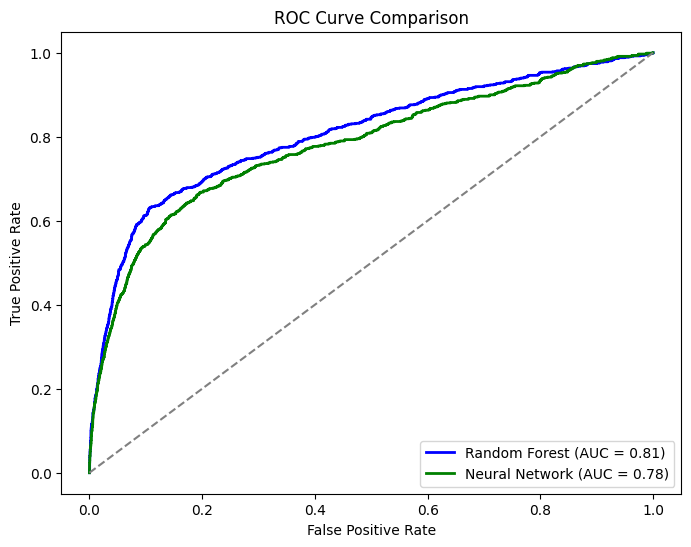

In [26]:
# Random Forest
random_probs = rand_classifier.predict_proba(X_test)[:, 1]

# Neural Network
neural_probs = neural_model.predict(X_test).ravel()

# Computing ROC curve and AUC - Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, random_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Computing ROC curve and AUC - Neural Network
fpr_nn,tpr_nn, _ = roc_curve(y_test, neural_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)

print(f'Random Forest (AUC = {roc_auc_rf:.2f})')
print(f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_nn, tpr_nn, color='green', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()
